This file is aimed towards beginners who are starting in the filed of deep learning and provides a step to step introduction to building a image classifier. This notebook uses the problem and dataset described in the [Deep Learning Beginner Challenge.](https://www.hackerearth.com/challenge/competitive/deep-learning-beginner-challenge/) at [HackerEarth](https://www.hackerearth.com/challenges/). 

### Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
%matplotlib inline

### Data Exploration 

In [2]:
# Reading the train and test csv files 
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Image_id,Animal
0,Img-1.jpg,hippopotamus
1,Img-2.jpg,squirrel
2,Img-3.jpg,grizzly+bear
3,Img-4.jpg,ox
4,Img-5.jpg,german+shepherd


Lets see which Animals are there in the dataset.

In [4]:
print('The dataset contain images of the following animals:\n\n', data.Animal.unique())

The dataset contain images of the following animals:

 ['hippopotamus' 'squirrel' 'grizzly+bear' 'ox' 'german+shepherd' 'buffalo'
 'otter' 'bobcat' 'wolf' 'persian+cat' 'collie' 'antelope' 'seal'
 'dalmatian' 'siamese+cat' 'moose' 'horse' 'killer+whale' 'mouse' 'walrus'
 'beaver' 'rhinoceros' 'chimpanzee' 'weasel' 'spider+monkey' 'raccoon'
 'rat' 'chihuahua' 'mole' 'bat']


### Data Visualization

Now, that we have explored our dataset, let's implement some data visualization techniques to get a better understand of the data.

We will first start by analysing the frequency distribution of the animal images in the training data.

In [5]:
animal_count = pd.value_counts(data.Animal)

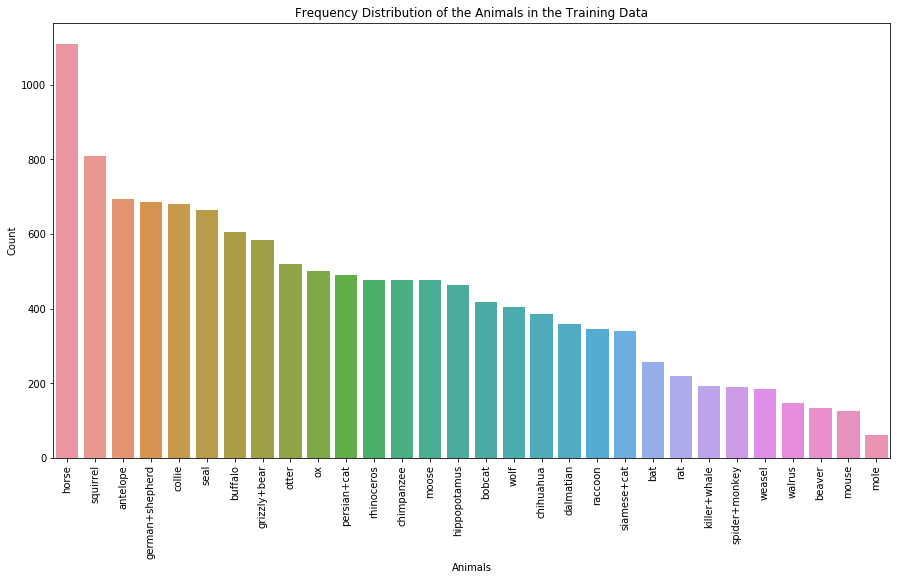

In [6]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=animal_count.index, y=animal_count.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)
ax.set_title('Frequency Distribution of the Animals in the Training Data')
ax.set(xlabel='Animals', ylabel='Count')
plt.show()

From the above distribution, we can infer that the animal 'horse' have the largest number of images in the dataset while 'mole' has the least number of images.

The distribution of the animals is skewed i.e. the classes to predict are unbalanced in the dataset. 

In [7]:
### Checking for any null values in the labels 
labels  = data.Animal
labels.isnull().any()

False

Now, let's visulize the Images in the training data.

In [8]:
### Train adn Test image folder paths

TRAIN_PATH = '/Users/varishaganesh/Machine Learning/train/train/'

Importing OpenCV and Python Image library for image manipulation.

In [9]:
### Importing Python Image Library and Opencv library
from PIL import Image
import cv2

Now, let's use OpenCV to read the Image.

In [10]:
img = cv2.imread(TRAIN_PATH+data.Image_id[0])

We used the OpenCV 'imread' function and read the image stored at index zero of the train data.

Now, let's look how the computer interprets the image.

In [11]:
img

array([[[101, 103, 113],
        [ 96,  98, 108],
        [101, 103, 113],
        ...,
        [ 50,  45,  42],
        [ 48,  43,  40],
        [ 29,  24,  21]],

       [[105, 106, 116],
        [104, 106, 116],
        [110, 112, 122],
        ...,
        [ 48,  41,  38],
        [ 52,  45,  42],
        [ 49,  42,  39]],

       [[ 97,  98, 108],
        [ 98,  99, 109],
        [107, 108, 118],
        ...,
        [ 55,  48,  45],
        [ 48,  39,  36],
        [ 46,  37,  34]],

       ...,

       [[ 51,  64,  80],
        [ 49,  62,  78],
        [ 48,  61,  75],
        ...,
        [ 46,  60,  78],
        [ 46,  62,  79],
        [ 46,  62,  79]],

       [[ 50,  62,  74],
        [ 49,  60,  74],
        [ 49,  60,  74],
        ...,
        [ 44,  58,  76],
        [ 45,  59,  77],
        [ 45,  59,  77]],

       [[ 54,  63,  76],
        [ 52,  64,  76],
        [ 52,  64,  76],
        ...,
        [ 43,  57,  75],
        [ 44,  59,  75],
        [ 43,  58,  74]]

The computer cannot see shapes or colors. It reads an image as an array of numbers.

Next, we will check the dimensions of this array. 

In [12]:
### Shape of the image.
img.shape

(1024, 576, 3)

So, the computer inteprets the image as a three dimensional array of 1024 rows and 576 columns and with depth 3.  Each value in this array represents a pixel in the image, lying in the range (0 - 255). The depth 3 represents the RGB spectrum in the image. 

### Data Preprocessing 

Next, we will perform some preprocessing on the image data before supplying them to the training model.

In [13]:
### Displaying the image dimensions of the first five images in the training dataset. 
sample = data.head()
for idx in sample.Image_id:
    img = cv2.imread(TRAIN_PATH + idx)
    print('{} : {}'.format(idx, img.shape))

Img-1.jpg : (1024, 576, 3)
Img-2.jpg : (771, 1024, 3)
Img-3.jpg : (683, 1024, 3)
Img-4.jpg : (681, 1024, 3)
Img-5.jpg : (500, 332, 3)


We can see that all the images have different dimesions. But neural networks expect arrays of uniform dimensions as input. Therefore, we will resize the images in the dataset to the dimensions : (224 x 224 x 3)

In [14]:
### Creating a function to resize the images in the training data.
from tqdm import tqdm
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    return img

The above function reads an image and resizes it to 224 x 224 dimensions and returns it. 

In [15]:
train_img = []
for img_path in tqdm(data.Image_id.values):
    train_img.append(read_img(TRAIN_PATH + img_path))

100%|██████████| 13000/13000 [04:15<00:00, 50.97it/s]


Next, we will rescale the images in the training data. We will scale the width and height of each image so that each pixel value lies in the range of [0 - 1]. We will rescale each image by dividing it by 255. 

In [16]:
# Convert the image data into an array. 
# Since the range of color(RGB) is in the range of (0-255).
# Hence by dividing each image by 255, we convert the range to (0.0 - 1.0)

train_and_test = np.array(train_img, np.float32) / 255.

In [17]:
print (len(train_and_test))

13000


In [18]:
limit = (80*len(train_and_test))//100
X_train = train_and_test[:limit]
X_test = train_and_test[limit:]

Next, we will calculate the mean and standard deviation of the images in the training dataset.

In [19]:
mean_img = X_train.mean(axis = 0)

In [20]:
std_dev = X_train.std(axis = 0)

Next, we will normalize the image data using the following formula: 

<center>** X = (x - mean of x)/(std. deviation of x)**<center/>

Normalization helps us to standardize the input values. Standardizing the inputs can make training faster and reduce the chances of getting stuck in local minima. Also, we like the features to haves similar ranges so that our gradients don't go out of control.

In [21]:
X_norm = (X_train - mean_img)/ std_dev

In [22]:
X_norm.shape

(10400, 224, 224, 3)

Next we label encode the lables in the train data. Label Encoding is used to transform non-numerical labels or categporical labels to numerical lables. 

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
lb = LabelEncoder()
lb.fit(data.Animal.values[:limit])
y = lb.transform(data.Animal.values[:limit])

In [69]:
data.Animal[limit:]

10400          beaver
10401            seal
10402             bat
10403        squirrel
10404    hippopotamus
             ...     
12995             bat
12996              ox
12997        squirrel
12998        squirrel
12999        squirrel
Name: Animal, Length: 2600, dtype: object

In [73]:
lb2 = LabelEncoder()
lb2.fit(data.Animal.values[limit:])
test_labels = lb2.transform(data.Animal.values[limit:])
len(test_labels)

2600

In [26]:
from sklearn.model_selection import train_test_split

Finally, we create the training and validation sets. 

In [27]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_norm, y, test_size=0.15)

### Model Architecture


We will use the Keras framework to create our model. 

In [28]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


Next, we will one-hot encode the labels before supplying them to the model. Since label encoding (a.k.a integer encoding) will have a ordinal relationship between them. But for categorical variables where no such ordinall relationship exists, the integer encoding is not enough. In this case, one-hot encoding can be applied to the integer representation, where the integer enocoded variable is removed and a new binary variable is added for each unique integer value.  

In [77]:
#### One hot encoding labels.
ytrain = np_utils.to_categorical(ytrain)
yvalid = np_utils.to_categorical(yvalid)

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

We will build a model from scratch. We will use a Sequential model, which is a linear stack of layers, to build this model. 

In [30]:
model = Sequential()
model.add(BatchNormalization(input_shape = Xtrain.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(30, activation='softmax'))

In [31]:
### Generating a summary of the model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 128)    

Next, we will define the loss function and the optimizer for the model.

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
early_stops = EarlyStopping(patience=5, monitor='val_acc')
checkpointer = ModelCheckpoint(filepath='weights.best.eda.hdf5', verbose=1, save_best_only=True)

In [34]:
model.fit(Xtrain, ytrain, validation_data=(Xvalid, yvalid), epochs=2, batch_size=16, verbose=1)

Train on 8840 samples, validate on 1560 samples
Epoch 1/2
8840/8840 [==============================] - 4777s 540ms/step - loss: 3.2542 - accuracy: 0.0941 - val_loss: 3.1235 - val_accuracy: 0.1365
Epoch 2/2
8840/8840 [==============================] - 4571s 517ms/step - loss: 3.0529 - accuracy: 0.1360 - val_loss: 2.9840 - val_accuracy: 0.1628


In [35]:
model.save_weights('weights.best.eda.hdf5')

### Prediction on Test Set

Now that we have built and trained our model, we will use it to predict the labels on the test images. 

Performing normalization on the test images. 

In [36]:
X_norm_test = (X_test - mean_img) / std_dev

Predicting the labels on the test images.

In [37]:
y_test_pred = model.predict(X_norm_test)

In [120]:
df = pd.DataFrame()
df['Image_id'] = data.Image_id[limit:]
label_df = pd.DataFrame(data=y_test_pred, columns=lb.classes_)
label_df
df

,Image_id
10400,Img-10401.jpg
10401,Img-10402.jpg
10402,Img-10403.jpg
10403,Img-10404.jpg
10404,Img-10405.jpg
...,...
12995,Img-12996.jpg
12996,Img-12997.jpg
12997,Img-12998.jpg
12998,Img-12999.jpg


In [135]:
final_output = label_df.idxmax(axis=1)
predictions = []
for i in final_output:
    predictions.append(i)
final_output

0                    ox
1                  seal
2                 horse
3              antelope
4                  seal
5               buffalo
6               buffalo
7              squirrel
8                 horse
9              squirrel
10                horse
11                 seal
12                 seal
13             squirrel
14             antelope
15                 seal
16                horse
17            dalmatian
18                horse
19              buffalo
20                 seal
21             antelope
22                 seal
23                 seal
24               collie
25             squirrel
26                horse
27                 seal
28                 seal
29                horse
30                 seal
31             antelope
32                 seal
33         grizzly+bear
34                 seal
35                horse
36                horse
37                 seal
38                 seal
39              buffalo
40             antelope
41              

In [122]:
table.to_csv('predicted_animals_train.csv', index=False)

In [134]:
gold_labels = []
test_labels = data.Animal[10400:]
for i in test_labels:
    gold_labels.append(i)
gold_labels

['beaver',
 'seal',
 'bat',
 'squirrel',
 'hippopotamus',
 'hippopotamus',
 'buffalo',
 'otter',
 'horse',
 'otter',
 'dalmatian',
 'walrus',
 'rat',
 'bobcat',
 'squirrel',
 'siamese+cat',
 'ox',
 'dalmatian',
 'chimpanzee',
 'rhinoceros',
 'collie',
 'squirrel',
 'otter',
 'horse',
 'squirrel',
 'grizzly+bear',
 'horse',
 'mouse',
 'otter',
 'grizzly+bear',
 'persian+cat',
 'squirrel',
 'squirrel',
 'buffalo',
 'horse',
 'beaver',
 'german+shepherd',
 'german+shepherd',
 'chimpanzee',
 'ox',
 'ox',
 'antelope',
 'otter',
 'persian+cat',
 'mole',
 'buffalo',
 'horse',
 'chihuahua',
 'walrus',
 'chihuahua',
 'persian+cat',
 'raccoon',
 'horse',
 'raccoon',
 'wolf',
 'chihuahua',
 'grizzly+bear',
 'persian+cat',
 'dalmatian',
 'raccoon',
 'seal',
 'collie',
 'hippopotamus',
 'mole',
 'antelope',
 'grizzly+bear',
 'squirrel',
 'antelope',
 'wolf',
 'chimpanzee',
 'chihuahua',
 'bat',
 'rhinoceros',
 'wolf',
 'seal',
 'collie',
 'rhinoceros',
 'collie',
 'hippopotamus',
 'moose',
 'hippop

In [136]:
from sklearn.metrics import classification_report
print(classification_report(gold_labels, predictions))

                 precision    recall  f1-score   support

       antelope       0.34      0.36      0.35       144
            bat       0.00      0.00      0.00        68
         beaver       0.00      0.00      0.00        20
         bobcat       0.00      0.00      0.00        82
        buffalo       0.12      0.10      0.11       105
      chihuahua       0.00      0.00      0.00        72
     chimpanzee       0.31      0.04      0.07        96
         collie       0.07      0.01      0.02       134
      dalmatian       0.95      0.26      0.41        73
german+shepherd       0.11      0.03      0.04       153
   grizzly+bear       0.09      0.09      0.09       103
   hippopotamus       0.13      0.05      0.08        91
          horse       0.17      0.71      0.27       222
   killer+whale       0.00      0.00      0.00        38
           mole       0.00      0.00      0.00        19
          moose       0.10      0.05      0.06       103
          mouse       0.00    

The submission produces a score of 3.140. Remember that this score is the log-loss error and therefore a perfect model will have a score close to 0 . Hence this model can be further improved in many ways. A better model will be posted in future.

END......